# Week 8 
# Encoder Decoder LSTM & GRU
## Name :  Mandar Sanjay Chaudhari
## Reg : 220968222
## Section & Batch : B-1

In [2]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense

In [2]:
batch_size = 64  
epochs = 100 
latent_dim = 256  
num_samples = 10000

In [3]:
!!curl -O http://www.manythings.org/anki/hin-eng.zip
!!unzip hin-eng.zip

['Archive:  hin-eng.zip',
 '  inflating: hin.txt                 ',
 '  inflating: _about.txt              ']

In [4]:
data_path = "hin.txt"

# Preprocessing

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#load the data
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

#split the data into English and Hindi parts
english_texts = []
hindi_texts = []
for line in lines:
    if '\t' in line:
        english_text, hindi_text = line.split('\t')[0], line.split('\t')[1]
        english_texts.append(english_text)
        hindi_texts.append(hindi_text)

#tokenize the english sentences
english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(english_texts)
english_sequences = english_tokenizer.texts_to_sequences(english_texts)

#tokenize the hindi sentences
hindi_tokenizer = Tokenizer()
hindi_tokenizer.fit_on_texts(hindi_texts)
hindi_sequences = hindi_tokenizer.texts_to_sequences(hindi_texts)

#pad the sequences
english_data = pad_sequences(english_sequences, padding='post')
hindi_data = pad_sequences(hindi_sequences, padding='post')

In [7]:
import numpy as np
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 3061
Number of unique input tokens: 70
Number of unique output tokens: 92
Max sequence length for inputs: 107
Max sequence length for outputs: 123


# 1) LSTM Model

In [8]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model_lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_lstm.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history_lstm = model_lstm.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=30,
          validation_split=0.2)



Epoch 1/30


39/39 [==============================] - 35s 711ms/step - loss: 1.2933 - accuracy: 0.7858 - val_loss: 1.7533 - val_accuracy: 0.6845
Epoch 2/30
39/39 [==============================] - 26s 662ms/step - loss: 0.9996 - accuracy: 0.8080 - val_loss: 1.4487 - val_accuracy: 0.6861
Epoch 3/30
39/39 [==============================] - 26s 658ms/step - loss: 0.8821 - accuracy: 0.8089 - val_loss: 1.4035 - val_accuracy: 0.6869
Epoch 4/30
39/39 [==============================] - 24s 625ms/step - loss: 0.8438 - accuracy: 0.8086 - val_loss: 1.5269 - val_accuracy: 0.6869
Epoch 5/30
39/39 [==============================] - 24s 630ms/step - loss: 0.8243 - accuracy: 0.8086 - val_loss: 1.3839 - val_accuracy: 0.6869
Epoch 6/30
39/39 [==============================] - 24s 618ms/step - loss: 0.8122 - accuracy: 0.8087 - val_loss: 1.3619 - val_accuracy: 0.6748
Epoch 7/30
39/39 [==============================] - 24s 621ms/step - loss: 0.7921 - accuracy: 0.8083 - val_loss: 1.3911 - val_accuracy: 0.

In [9]:
model_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 70)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 92)]           0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                334848    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

# 2) GRU Model

In [10]:
encoder_gru = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder_gru(encoder_inputs)

encoder_states_gru = [state_h]

decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs_gru, _ = decoder_gru(decoder_inputs,
                                     initial_state=encoder_states_gru)
decoder_dense_gru = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs_gru = decoder_dense_gru(decoder_outputs_gru)

model_gru = Model([encoder_inputs, decoder_inputs], decoder_outputs_gru)

model_gru.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history_gru = model_gru.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=30,
          validation_split=0.2)

Epoch 1/30
39/39 [==============================] - 30s 580ms/step - loss: 1.3613 - accuracy: 0.7860 - val_loss: 1.6024 - val_accuracy: 0.6845
Epoch 2/30
39/39 [==============================] - 21s 540ms/step - loss: 0.9586 - accuracy: 0.8063 - val_loss: 1.6988 - val_accuracy: 0.6845
Epoch 3/30
39/39 [==============================] - 21s 542ms/step - loss: 0.9042 - accuracy: 0.8070 - val_loss: 1.3785 - val_accuracy: 0.6865
Epoch 4/30
39/39 [==============================] - 22s 555ms/step - loss: 0.8405 - accuracy: 0.8079 - val_loss: 1.3601 - val_accuracy: 0.6869
Epoch 5/30
39/39 [==============================] - 21s 543ms/step - loss: 0.7932 - accuracy: 0.8080 - val_loss: 1.2906 - val_accuracy: 0.6839
Epoch 6/30
39/39 [==============================] - 21s 550ms/step - loss: 0.7618 - accuracy: 0.8132 - val_loss: 1.2541 - val_accuracy: 0.6924
Epoch 7/30
39/39 [==============================] - 23s 583ms/step - loss: 0.7227 - accuracy: 0.8197 - val_loss: 1.1838 - val_accuracy: 0.7032

In [11]:
model_gru.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 70)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 92)]           0         []                            
                                                                                                  
 gru (GRU)                   [(None, 256),                251904    ['input_1[0][0]']             
                              (None, 256)]                                                        
                                                                                                  
 gru_1 (GRU)                 [(None, None, 256),          268800    ['input_2[0][0]',       

In [12]:
import matplotlib.pyplot as plt

#evaluate LSTM model
lstm_scores = model_lstm.evaluate([encoder_input_data, decoder_input_data], decoder_target_data, verbose=0)
print('LSTM Model:')
print('Test loss:', lstm_scores[0])
print('Test accuracy:', lstm_scores[1])

LSTM Model:
Test loss: 0.5779508352279663
Test accuracy: 0.8476266860961914


In [13]:
#evaluate GRU model
gru_scores = model_gru.evaluate([encoder_input_data, decoder_input_data], decoder_target_data, verbose=0)
print('\nGRU Model:')
print('Test loss:', gru_scores[0])
print('Test accuracy:', gru_scores[1])


GRU Model:
Test loss: 0.5398595929145813
Test accuracy: 0.8545589447021484


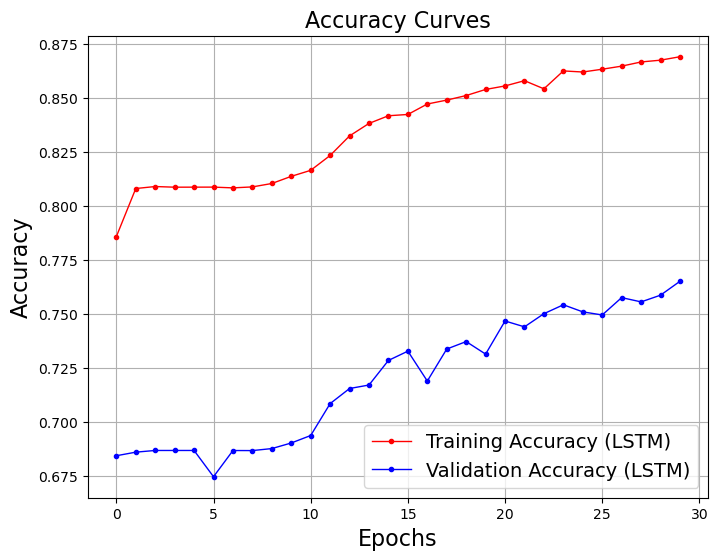

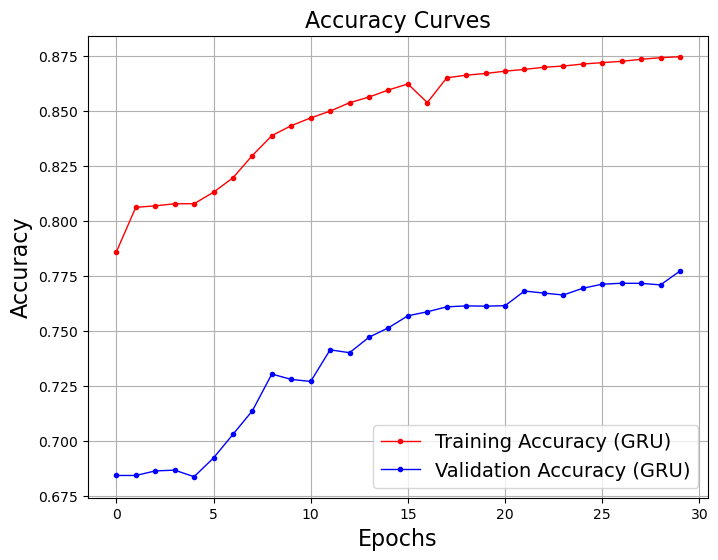

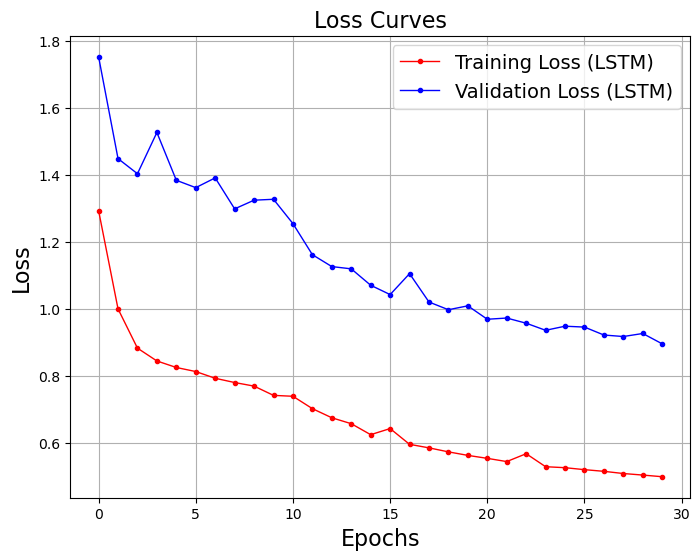

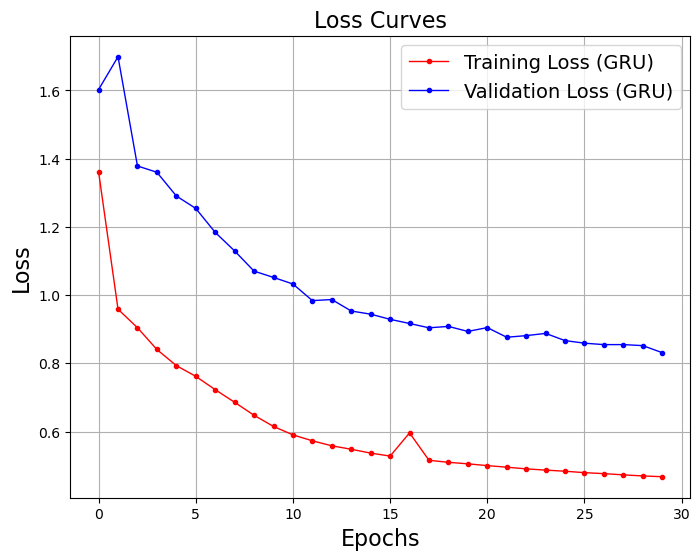

In [14]:
#plot accuracy and loss for LSTM and GRU models
plt.figure(figsize=[8,6])
plt.plot(history_lstm.history['accuracy'],'r-', marker='.', linewidth=1.0)
plt.plot(history_lstm.history['val_accuracy'],'b-', marker='.', linewidth=1.0)
plt.legend(['Training Accuracy (LSTM)', 'Validation Accuracy (LSTM)'],fontsize=14)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.grid(True)

plt.figure(figsize=[8,6])
plt.plot(history_gru.history['accuracy'],'r-', marker='.', linewidth=1.0)
plt.plot(history_gru.history['val_accuracy'],'b-', marker='.', linewidth=1.0)
plt.legend(['Training Accuracy (GRU)', 'Validation Accuracy (GRU)'],fontsize=14)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.grid(True)

plt.figure(figsize=[8,6])
plt.plot(history_lstm.history['loss'],'r-', marker='.', linewidth=1.0)
plt.plot(history_lstm.history['val_loss'],'b-', marker='.', linewidth=1.0)
plt.legend(['Training Loss (LSTM)', 'Validation Loss (LSTM)'],fontsize=14)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.grid(True)

plt.figure(figsize=[8,6])
plt.plot(history_gru.history['loss'],'r-', marker='.', linewidth=1.0)
plt.plot(history_gru.history['val_loss'],'b-', marker='.', linewidth=1.0)
plt.legend(['Training Loss (GRU)', 'Validation Loss (GRU)'],fontsize=14)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.grid(True)